# 电商打折套路分析

——2016天猫双十一美妆数据分析


## 数据简介
+ 此次分析的数据来自于城市数据团对2016年双11天猫数据的采集和整理，原始数据为.xlsx格式
+ 包括update_time/id/title/price/店名，共5个字段，其中id为商品的唯一标识，店名为品牌名。

## 分析工具
+ 主要使用了Python中的Pandas库进行数据处理，利用matplotlib绘制分析图表，利用bokeh进行了可视化展示。  

+ 当前使用版本：Python 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]

## 说明
+ 本次数据分析主要供学习使用，目的在于熟悉Python及相关库，同时练习数据分析的思维方式。
+ 本次分析主要基于描述性统计，暂不包含预测模型。
+ 文字说明会涉及实现的具体细节，而不仅是分析结果的展示。

## 分析目标
+ 商品销售时间分析
    1. 统计出商品总数和品牌总数
    2. 计算双十一当天在售商品占比
    3. 未参与双十一当天活动的商品，双十一之后的去向
    4. 参加双十一活动的品牌及其商品数量的分布  
+ 价格折扣分析
    1. 针对每个商品，分析其价格变化，判断是否打折
    2. 针对在打折商品，计算其折扣率
    3. 按照品牌分析，不同品牌的打折力度 
    4. 分析商家打折套路    
+ 构建商品id/品牌的汇总表
    1. 商品id资料表格
    2. 品牌汇总资料表格
    3. 假打折商品详情

## 正文
### 相关模块导入

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore') 
# 不发出警告

from bokeh.io import output_notebook
output_notebook()
# 导入notebook绘图模块
from bokeh.plotting import figure,show
from bokeh.models import ColumnDataSource
# 导入图表绘制、图标展示模块
# 导入ColumnDataSource模块

import os

Loading BokehJS ...

### 加载数据和数据预处理
+ 设置工作路径，pandas导入数据
+ 检查数据是否有缺失值
+ 检查数据类型
+ 对数据进行基本预处理
+ 查看数据

In [2]:
# 加载数据
os.chdir('C:\\Project\\DataAnalysis\\R2\\电商打折分析\\')
data = pd.read_excel('双十一淘宝美妆数据.xlsx')


data[data.isnull().values == True].drop_duplicates
# 检查缺失值

data.dtypes
# 查看数据类型

update_time    datetime64[ns]
id                     object
title                  object
price                 float64
店名                     object
dtype: object

In [3]:
data.index = data['update_time']
data['date'] = data.index.day
# Series没有.day方法，利用index做了一步转换

data = data.drop('update_time', axis = 1)
data.reset_index(inplace = True)
data.rename(columns = {'店名': 'brand'}, inplace = True)

data.head()

,update_time,id,title,price,brand,date
0,2016-11-14,A2251521828,相宜本草四倍多萃润泽精华保湿霜滋润面霜女补水,79.0,相宜本草,14
1,2016-11-14,A2251610120,正品相宜本草四倍多萃润泽洁面膏深层清洁滋润补水保湿,29.0,相宜本草,14
2,2016-11-14,A2251615486,相宜本草红石榴亮白嫩肤水女紧致补水保湿精华爽肤水女秋冬护肤品,108.0,相宜本草,14
3,2016-11-14,A2252191048,相宜本草红石榴鲜活透亮面贴膜7片补水保湿女化妆品滋润,79.0,相宜本草,14
4,2016-11-14,A2253094636,相宜本草去死皮膏洁净面部全身温和去角质补水化妆,35.0,相宜本草,14


### Part1 商品销售时间分析
    1. 统计出商品总数和品牌总数
    2. 计算双十一当天在售商品占比
    3. 未参与双十一当天活动的商品，双十一之后的去向
    4. 参加双十一活动的品牌及其商品数量的分布 

#### 统计商品总数 / 品牌总数

In [4]:
data1 = data[['id','title', 'brand', 'price', 'date']]

items_num = len(data1['id'].unique())
brands_num = len(data1['brand'].unique())

print('商品总数为: %d' %items_num)
print('品牌总数为: %d' %brands_num)

商品总数为: 3502
品牌总数为: 22


#### 计算双十一当天在售商品占比

In [5]:
items_at11 = data1[data1['date'] == 11].drop_duplicates()
items_at11_num = len(items_at11)
precentage_11 = items_at11_num / items_num

print('双十一当天在售商品占比为: %.2f%%' %(precentage_11 * 100))

双十一当天在售商品占比为: 66.68%


#### 商品销售情况分类
为了分析没参加双十一的产品去向，我们首先对所有商品id依据其上架时间进行分类。  
根据date字段，统计每件商品的最早和最迟销售时间；再统计双11当天是否销售；最后进行分类。 
   + A. 11.11前后及当天都在售 → 一直在售
   + B. 11.11之后停止销售 → 双十一后停止销售
   + C. 11.11开始销售并当天不停止 → 双十一当天上架并持续在售
   + D. 11.11开始销售且当天停止 → 仅双十一当天有售
   + E. 11.5 - 11.9 → 双十一前停止销售
   + F. 仅11.11当天停止销售 → 仅双十一当天停止销售
   + G. 11.12开始销售 → 双十一后上架
   + H. 11.10下架 → 可能11.11售罄 以后单独分析

In [6]:
# 分析商品最早/最迟销售时间，及双11当天销售情况
data_sellrange = data1.groupby('id')['date'].agg(['min', 'max'])
id_at11 = data1[data1['date'] == 11]['id']

data_temp1 = pd.DataFrame({'id': id_at11, 'on11sale': True})

data1_id = pd.merge(data_sellrange, data_temp1, left_index = True, right_on = 'id', how = 'left')
data1_id.fillna(False, inplace = True)
data1_id['type'] = 'unclassified'
data1_id = data1_id.reset_index()
data1_id = data1_id.drop('index', 1)

data1_id.head()

,min,max,id,on11sale,type
0,5,14,A10027317366,True,unclassified
1,5,14,A10588608182,True,unclassified
2,5,14,A10847151685,True,unclassified
3,5,10,A12229499633,False,unclassified
4,5,11,A12229615671,True,unclassified


In [7]:
# 分类
data1_id = data1_id.reset_index()
data1_id = data1_id.drop('index', 1)

data1_id['type'][(data1_id['min'] < 11) & (data1_id['max'] > 11)] = 'A'
data1_id['type'][(data1_id['min'] < 11) & (data1_id['max'] == 11)] = 'B'
data1_id['type'][(data1_id['min'] == 11) & (data1_id['max'] > 11)] = 'C'
data1_id['type'][(data1_id['min'] == 11) & (data1_id['max'] == 11)] = 'D'
data1_id['type'][data1_id['on11sale'] == False] = 'F'
# 此时的F还包括E/H的情况
data1_id['type'][data1_id['max'] < 10] = 'E'
data1_id['type'][data1_id['min'] > 11] = 'G'
data1_id['type'][data1_id['max'] == 10] = 'H'

data1_id[data1_id['type'] == 'unclassified']
# 检查分类是否完备


,min,max,id,on11sale,type


([<matplotlib.patches.Wedge at 0x24ae12d2160>,
 [Text(1.6468,-0.102777,'A'),
  Text(-0.841815,-1.4191,'B'),
  Text(-1.37136,-0.917537,'C'),
  Text(-1.41645,-0.846266,'D'),
  Text(-1.50769,-0.670349,'E'),
  Text(-1.64219,-0.160302,'F'),
  Text(-1.61871,0.319812,'G'),
  Text(-0.998822,1.31334,'H')],
 [Text(1.19767,-0.0747471,'51.98%'),
  Text(-0.612229,-1.03207,'13.07%'),
  Text(-0.997352,-0.667299,'1.11%'),
  Text(-1.03015,-0.615466,'0.51%'),
  Text(-1.0965,-0.487527,'3.31%'),
  Text(-1.19432,-0.116583,'6.91%'),
  Text(-1.17724,0.232591,'2.40%'),
  Text(-0.726416,0.955154,'20.70%')])

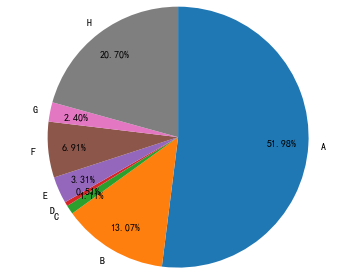

In [8]:
# 分类的可视化
result1 = data1_id['type'].value_counts()
# 用于可视化的数据命名为result
result1 = result1.loc[['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']]
# 用于调整Series中Index的顺序

plt.rcParams['font.sans-serif']=['SimHei']
# 用来正常显示中文标签
plt.axis('equal')
# 保证长宽相等 --> 饼图为圆形
plt.pie(result1,labels = result1.index, autopct='%.2f%%',pctdistance=0.8,labeldistance =1.1,
        startangle=90, radius=1.5,counterclock=False)                 
# 绘制饼图

#### 未参与双十一活动的商品去向分析

+ 暂时下架
+ 改名上架
+ 预售
+ 未参与活动

In [9]:
# 选择数据字段
id_not11 = data1_id[data1_id['on11sale'] == False]
df_not11 = id_not11[['id', 'type']]
# 此时没有title字段，需要找到data1合并
data1_not11 = pd.merge(df_not11, data1, how = 'left', on = 'id')
data1_not11.head()

,id,type,title,brand,price,date
0,A12229499633,H,【双11来啦】专柜正品相宜本草芯净自然控油洁面两用卸妆乳补水,相宜本草,49.0,10
1,A12229499633,H,【双11来啦】专柜正品相宜本草芯净自然控油洁面两用卸妆乳补水,相宜本草,49.0,9
2,A12229499633,H,【双11来啦】专柜正品相宜本草芯净自然控油洁面两用卸妆乳补水,相宜本草,49.0,8
3,A12229499633,H,【双11来啦】专柜正品相宜本草芯净自然控油洁面两用卸妆乳补水,相宜本草,49.0,7
4,A12229499633,H,【双11来啦】专柜正品相宜本草芯净自然控油洁面两用卸妆乳补水,相宜本草,49.0,6


In [10]:
# case1 暂时下架
not11_case1 = data1_not11[data1_not11['type'] == 'F']['id'].drop_duplicates()
id_case1 = not11_case1.reset_index().drop('index', 1)
id_case1['case1'] = 1
# .unique()出现numpy数组，drop_duplicates()返回Series

# case2 更名上架
not11_case2 = data1_not11.groupby(['id', 'title']).count().reset_index()
# 此时聚合的结果为每一个(id - title)对，对应的出现次数，即出现的日期和
title_count = not11_case2['id'].value_counts().reset_index()
# 计算id出现的次数，如果次数大于1，则说明商品更改过title
# reset_index() 使原来index里的信息成为一个新的列
id_case2 = title_count[title_count['id'] > 1][['index']]
id_case2.columns = ['id']
id_case2['case2'] = 1

# case3 预售
not11_case3 = data1_not11[data1_not11['title'].str.contains('预售')]
id_case3 = not11_case3['id'].drop_duplicates().reset_index().drop('index', 1)
# .unique() 返回ndarray / .drop_duplicates() 返回Serise
id_case3['case3'] = 1

# case4 未参与活动
not11_case4 = data1_not11[(data1_not11['type'] == 'E') | (data1_not11['type'] == 'G')]['id'].drop_duplicates()
id_case4 = not11_case4.reset_index().drop('index', 1)
id_case4['case4'] = 1

print("未参与双十一当天活动的商品中:\n暂时下架商品的数量为%i个，更名上架商品的数量为\
%i个，预售商品的数量为%i个，未参与活动商品数量为%i个" %(len(id_case1), len(id_case2), len(id_case3), len(id_case4)))


未参与双十一当天活动的商品中:
暂时下架商品的数量为242个，更名上架商品的数量为110个，预售商品的数量为453个，未参与活动商品数量为200个


In [11]:
# 查看没被分类的其他情况
id_not11_left = id_not11[['id', 'min', 'max', 'type']].reset_index()
id_not11_left = id_not11_left.drop('index', axis = 1)
#id_not11_left['case'] = ''
id_not11_left = pd.merge(id_not11_left, id_case1, how = 'left', on = 'id')
id_not11_left = pd.merge(id_not11_left, id_case2, how = 'left', on = 'id')
id_not11_left = pd.merge(id_not11_left, id_case3, how = 'left', on = 'id')
id_not11_left = pd.merge(id_not11_left, id_case4, how = 'left', on = 'id')
id_not11_left = id_not11_left.fillna(0)
id_not11_left['left'] = id_not11_left['case1'] + id_not11_left['case2'] + id_not11_left['case3'] + id_not11_left['case4']
id_not11_others = id_not11_left[id_not11_left['left'] == 0][['id', 'min', 'max', 'type']]

id_not11_others.head()
# 未纳入分类的商品都是10日下架的，可能于双11当天售罄
# 暂时下架/更名上架/预售 可能互相包含

,id,min,max,type
0,A12229499633,5,10,H
3,A12459717064,5,10,H
4,A12459730213,5,10,H
5,A12460337412,5,10,H
6,A12544615139,5,10,H


##### 查看双十一当天未上架商品的分布情况
分类有少量重复，没有被划分到的商品都是10号下架（H分类）的商品。事实上，由于采集数据仅是每天的一个时间点，这些未被分类的数据很可能是双十一当天售罄的商品。

In [12]:
id_others_type = id_not11_others['type'].value_counts()
id_not11_type = id_not11_left['left'].value_counts()
print(id_not11_left['type'].value_counts())
print('-' * 10)
print(id_others_type)
print('-' * 10)
print(id_not11_type)

H    725
F    242
E    116
G     84
Name: type, dtype: int64
----------
H    339
Name: type, dtype: int64
----------
1.0    707
0.0    339
2.0     65
3.0     56
Name: left, dtype: int64


#### 参加双十一活动的品牌及其商品数量的分布
 + 真正参与双十一活动的商品 = 双十一当天在售的商品 + 预售商品
 + 对暂时下架/更名上架/售罄商品 后续可以研究其价格变化再确定
 + 绘制堆叠图进行可视化

In [13]:
id_at11 = id_at11.reset_index().drop('index', 1)
id_presell = id_case3[['id']]
id_11all = pd.concat([id_at11, id_presell], ignore_index = True)
# 筛选双十一当日在售商品和预售商品id

id_presell['presell'] = True
id_11all['11all'] = True

data1_id = pd.merge(data1_id, id_presell, how = 'left', on = 'id')
data1_id.fillna(False, inplace = True)
data1_id = pd.merge(data1_id, id_11all, how = 'left', on = 'id')
data1_id.fillna(False, inplace = True)

data1_brand = data1[['id', 'brand']].drop_duplicates()
data1_id = pd.merge(data1_id, data1_brand, on = 'id', how = 'left')
# 合并数据 销售情况 id brand

data1_id.head()

,min,max,id,on11sale,type,presell,11all,brand
0,5,14,A10027317366,True,A,False,True,相宜本草
1,5,14,A10588608182,True,A,False,True,欧莱雅
2,5,14,A10847151685,True,A,False,True,佰草集
3,5,10,A12229499633,False,H,False,False,相宜本草
4,5,11,A12229615671,True,B,False,True,相宜本草


In [14]:
data1_on11sale = data1_id[data1_id['on11sale'] == True]
brand_on11sale = data1_on11sale.groupby('brand')['id'].count()

data1_presell = data1_id[data1_id['presell'] == True]
brand_presell = data1_presell.groupby('brand')['id'].count()
# 统计各品牌双十一当天在售和预售商品数量

In [15]:
# 利用bokeh绘制堆叠图
from bokeh.models import HoverTool
from bokeh.core.properties import value

result2 = pd.DataFrame({'on11sale': brand_on11sale,
                        'presell': brand_presell})
result2['11all'] = result2['on11sale'] + result2['presell']
result2.sort_values(by = '11all', inplace = True, ascending = False)

lst_brand = result2.index.tolist()
lst_type = result2.columns.tolist()[:2]
colors = ["#718dbf" ,"#e84d60"]
# 设置好参数

result2.index.name = 'brand'
# 重命名标签
source1 = ColumnDataSource(result2)
# 创建数据

hover1 = HoverTool(tooltips = [('品牌', '@brand'),
                               ('双十一当天参与活动商品数量', '@on11sale'),
                               ('预售商品数量', '@presell'),
                               ('参与双十一活动商品总数', '@11all')
                               ])
# 设置标签显示内容
#output_file('折扣商品数量.html')

p1 = figure(x_range = lst_brand,
            plot_width = 900, plot_height = 350,
            title = '各个品牌参与双十一活动的商品数量分布',
            tools = [hover1, 'reset, xwheel_zoom, pan, crosshair'])
# 构建绘图空间

p1.vbar_stack(stackers = lst_type,
              x = 'brand', source = source1,
              width = 0.9, color = colors, alpha = 0.8,
              legend = [value(x) for x in lst_type],
              muted_color = 'black', muted_alpha = 0.2)
# 绘制堆叠图

p1.xgrid.grid_line_color = None
p1.axis.minor_tick_line_color = None
p1.outline_line_color = None
p1.legend.location = "top_right"
p1.legend.orientation = "horizontal"
p1.legend.click_policy="mute"
# 设置其他参数

show(p1)

#### 补充品牌数据汇总

In [16]:
data1_brands = result2.copy()
brand_total_item = data1_brand.groupby('brand').count()
brand_total_item.columns = ['total_items']
data1_brands = pd.merge(data1_brands, brand_total_item, left_index = True, right_index = True, how = 'outer')

data1_brands.head()

,on11sale,presell,11all,total_items
brand,,,,
SKII,40,15,55,62
佰草集,208,32,240,279
倩碧,144,49,193,211
兰芝,107,4,111,156
兰蔻,112,27,139,168


### Part2 价格折扣分析
    1. 针对每个商品，分析其价格变化，判断是否打折
    2. 针对在打折商品，计算其折扣率
    3. 按照品牌分析，不同品牌的打折力度 
    4. 分析商家打折套路

#### 针对每个商品，评估其打折情况
 + 真打折：商品的价格在10天内有波动，双11价格为10天内最低价，无提前涨价
 + 假打折：双十一之前存在涨价现象
 + 不打折：商品价格无变化

In [17]:
data2 = data[['id', 'title', 'brand', 'price', 'date']]
data2['period'] = pd.cut(data2['date'], [4, 10, 11, 14], labels = ['双十一前', '双十一当天', '双十一后'])
# 筛选数据

data2_price = data2[['id', 'price', 'period']].groupby(['id', 'period']).agg(['min', 'max'])
data2_price.reset_index(inplace = True)
data2_price.columns = ['id', 'period', 'min_price', 'max_price']
# 找到每个时段对应的最高和最低价格

data2_price_before11 = data2_price[data2_price['period'] == '双十一前']
# 分析双十一之前的价格变化 --> 分析属于提前降价还是假打折(先涨价后降价)
data2_price_before11_diff = data2_price_before11[data2_price_before11['min_price'] != data2_price_before11['max_price']].reset_index().drop('index', 1)
# 找出双十一前价格变化的商品
diff_id = data2_price_before11_diff['id'].tolist()

data2_diffprice = pd.merge(data2, data2_price_before11_diff, on = 'id', how = 'left')
# 与原始数据合并，查看价格变化商品的具体情况
data2_diffpriceonly = data2_diffprice.dropna()
data2_diffpriceonly.drop('period_y', 1, inplace = True)
# 删除多余的列和缺失值

before11_diff = data2_diffpriceonly[data2_diffpriceonly['period_x'] != '双十一后'].reset_index().drop('index', 1)
# 只查看双十一之前和当天的数据
before_11diffprice = before11_diff.pivot_table(index = 'id', columns = 'date', aggfunc = {'price':min})
# 数据透视表
before_11diffprice.columns = [5, 6, 7, 8, 9, 10, 11]
# 列名改用数字，不用字符串，方便运算

def function(df, *colnums):
    a = 0
    for colnum in colnums:
        if df[colnum + 1] - df[colnum] > 0.1:
            a = 1
    return a

before_11diffprice['jdz'] = before_11diffprice.apply(lambda x: function(x, 5, 6, 7, 8, 9), axis = 1)
# 选择出涨价的商品在假打折列名标注1
# 只统计涨价1毛以上的
# DataFrame.apply函数的应用，如果设置axis参数为1则每次函数每次会取出DataFrame的一行来做处理

jdz_num = before_11diffprice['jdz'].sum()
# 共有16件商品假打折
jdz_items = pd.merge(data1_id, before_11diffprice, on = 'id', how = 'right')
jdz_items = jdz_items[jdz_items['jdz'] == 1]
jdz_items = jdz_items[jdz_items['jdz'] == 1].reset_index().drop('index', 1)

jdz_id = jdz_items[['id', 'jdz']]
# 提取假打折商品id

jdz_items

,min,max,id,on11sale,type,presell,11all,brand,5,6,7,8,9,10,11,jdz
0,5,14,A12727688676,True,A,False,True,美宝莲,60.0,60.0,60.0,60.0,60.0,67.0,59.0,1
1,5,14,A18054717031,True,A,False,True,妮维雅,42.0,42.0,NaN,42.0,42.0,44.5,37.0,1
2,5,14,A22708800014,True,A,False,True,妮维雅,154.5,154.5,154.5,154.5,154.5,174.0,138.0,1
3,5,14,A38544698582,True,A,False,True,美加净,49.0,49.0,49.0,49.0,49.0,53.4,39.0,1
4,5,14,A38960298831,True,A,False,True,美加净,13.8,13.8,13.8,13.8,13.8,53.4,39.0,1
5,5,14,A41781939432,True,A,False,True,妮维雅,94.5,94.5,94.5,94.5,94.5,109.0,85.0,1
6,5,14,A42058272267,True,A,False,True,妮维雅,42.0,42.0,NaN,42.0,42.0,44.5,37.0,1
7,5,14,A42152414491,True,A,False,True,妮维雅,259.0,259.0,259.0,259.0,259.0,284.5,233.0,1
8,5,10,A43251089044,False,H,False,False,兰蔻,610.0,610.0,610.0,795.0,795.0,795.0,NaN,1
9,5,14,A520423892639,True,A,False,True,妮维雅,59.0,59.0,59.0,59.0,59.0,99.0,53.1,1


观察数据可知
+ 假打折商品的品牌集中于妮维雅和美加净(各6件)，美宝莲有1件
+ 兰蔻有一件商品在双十一前涨价后，双十一当日下架
+ SKII和薇姿各有一件商品涨价后，双十一当天维持该价格
+ 大牌套路深，深知法律风险，但这四件商品依旧被划分在假打折！

In [18]:
data2_nocheat = pd.merge(data2, jdz_id, on = 'id', how = 'left')
data2_nocheat['jdz'].fillna(0, inplace = True)
data2_nocheat = data2_nocheat[data2_nocheat.jdz.isin([0])]
# 根据列条件删除行使用.isin(),参数为列表，如选择不包含，前面加负号
# 提取非假打折商品

price = data2_nocheat[['id', 'price', 'period']].groupby(['id', 'price']).min()
price.reset_index(inplace = True)
# 针对每个商品做price字段的value值统计，查看价格是否有波动

id_count = price['id'].value_counts()
id_type1 = id_count[id_count == 1].index
# 价格无波动，不打折
id_type2 = id_count[id_count != 1].index
# 价格变动

n1 = len(id_type1)
n2 = len(id_type2)
print('真打折的商品数量约占比%.2f%%，不打折的商品数量约占比%.2f%%, 假打折的商品数量约占比%.2f%%' % \
      (n2/items_num * 100, n1/items_num * 100, jdz_num/items_num * 100))
# 计算打折商品比例

真打折的商品数量约占比24.27%，不打折的商品数量约占比75.27%, 假打折的商品数量约占比0.46%


#### 针对在打折商品，计算其折扣率
+ 去除假打折商品
+ 考虑双十一价格对比其前后的折扣率，主要考虑前折扣率
+ 只计算九五折以上折扣

In [19]:
result3_pivot = data2_nocheat.pivot_table(index = 'id', columns = 'period', aggfunc = {'price': min})
# 数据透视可以一步到位，省却无数步骤
result3_pivot.columns = ['price_before11', 'price_on11', 'price_after11']
result3_pivot = result3_pivot.reset_index()

nocheat_idbrand = data2_nocheat[['id', 'brand']].drop_duplicates()
result3_final = pd.merge(result3_pivot, nocheat_idbrand, on = 'id').reset_index().drop('index', 1)
# 与品牌名合并

result3_final['qzkl'] = result3_final['price_on11'] / result3_final['price_before11']
result3_final['hzkl'] = result3_final['price_on11'] / result3_final['price_after11']
# 计算商品的前后折扣率

result3_on11 = result3_final.dropna()
# 筛选出双十一销售商品的折扣率
result3_zk = result3_on11[result3_on11['qzkl'] < 0.96].reset_index()
# 筛选出真打折的商品

result3_zk.head()

,index,id,price_before11,price_on11,price_after11,brand,qzkl,hzkl
0,0,A10027317366,188.0,159.00,258.0,相宜本草,0.845745,0.616279
1,2,A10847151685,180.0,125.99,240.0,佰草集,0.699944,0.524958
2,8,A12455538031,79.0,69.00,79.0,美宝莲,0.873418,0.873418
3,26,A12591129422,189.0,179.00,250.0,玉兰油,0.947090,0.716000
4,35,A12620798148,238.0,219.00,260.0,玉兰油,0.920168,0.842308


In [20]:
## 用bokeh绘制折线图：x轴为折扣率，y轴为商品数量占比
## 商品折扣率统计，每个折扣区间与总打折商品占比
bokeh_data = result3_zk[['id', 'qzkl']]
bokeh_data['zkl_range'] = pd.cut(bokeh_data['qzkl'], bins = np.linspace(0, 1, 21))
# 创建折扣率区间

bokeh_data2 = bokeh_data.groupby('zkl_range').count().iloc[:-1]
bokeh_data2['zkl_pre'] = bokeh_data2['qzkl'] / bokeh_data2['qzkl'].sum()
# 将数据按照折扣率拆分为不同区间，并统计不同1扣率的商品数量

bokeh_data2 = bokeh_data2.reset_index().drop('id', axis = 1)
bokeh_data2.dtypes
# 查看bokeh_data2数据类型，zkl_range类型为category --> str
bokeh_data2['zkl_range'] = bokeh_data2['zkl_range'].astype(str)
# bokeh_data2['zkl_range'] = list(map(str,bokeh_data2['zkl_range']))

bokeh_data2.head()

,zkl_range,qzkl,zkl_pre
0,"(0.0, 0.05]",0,0.000000
1,"(0.05, 0.1]",0,0.000000
2,"(0.1, 0.15]",1,0.001828
3,"(0.15, 0.2]",1,0.001828
4,"(0.2, 0.25]",0,0.000000


In [21]:
#output_file('商品折扣率统计折线图.html')

source2 = ColumnDataSource(bokeh_data2)
lst_zkl = bokeh_data2['zkl_range'].tolist()
# 此时列表中每个元素均为str

hover2 = HoverTool(tooltips = [('折扣商品数量', '@qzkl')])

p2 = figure(x_range = lst_zkl,
            plot_width = 900, plot_height = 350,
            title = '商品折扣率统计',
            tools = [hover2, 'reset, xwheel_zoom, pan, crosshair'])
# 构建绘图空间

p2.line(x = 'zkl_range', y = 'zkl_pre', source = source2,
        line_width = 2, line_alpha = 0.8, line_color = 'black', line_dash = [10, 4])

p2.circle(x = 'zkl_range', y = 'zkl_pre', source = source2,
          size = 8, color = 'red', alpha = 0.8)

p2.xgrid.grid_line_color = None
p2.axis.minor_tick_line_color = None
p2.outline_line_color = None
# 设置其他参数
show(p2)

观察上图可知，商品折扣率主要集中在五折和九折，二者共占50%以上

#### 根据商品id汇总数据
+ 包括商品销售时间和价格折扣数据

In [22]:
result3_zk['zk'] = 1

# 根据id汇总数据
jdz_merge = jdz_items[['id', 'jdz']]
result3_zk_merge = result3_zk[['id', 'zk']]
data2_id = pd.merge(result3_final, jdz_merge, on = 'id', how = 'outer')
data2_id['jdz'].fillna(0, inplace = True)
data2_id = pd.merge(data2_id, result3_zk_merge, on = 'id', how = 'outer')
data2_id['zk'].fillna(0, inplace = True)
# 整理商品id的折扣情况

data1_id = data1_id.drop_duplicates()
# 商品销售情况去重

data_id = pd.merge(data1_id, data2_id, on = 'id', how = 'outer')
data_id.drop('brand_y', axis = 1, inplace = True)
data_id.rename(columns = {'min': 'begin', 'max': 'end', 'brand_x': 'brand'}, inplace = True)
# 汇总商品id的全数据

data_id.head()

,begin,end,id,on11sale,type,presell,11all,brand,price_before11,price_on11,price_after11,qzkl,hzkl,jdz,zk
0,5,14,A10027317366,True,A,False,True,相宜本草,188.0,159.00,258.0,0.845745,0.616279,0.0,1.0
1,5,14,A10588608182,True,A,False,True,欧莱雅,189.0,189.00,249.0,1.000000,0.759036,0.0,0.0
2,5,14,A10847151685,True,A,False,True,佰草集,180.0,125.99,240.0,0.699944,0.524958,0.0,1.0
3,5,10,A12229499633,False,H,False,False,相宜本草,NaN,NaN,49.0,NaN,NaN,0.0,0.0
4,5,11,A12229615671,True,B,False,True,相宜本草,NaN,39.50,79.0,NaN,0.500000,0.0,0.0


#### 根据品牌汇总数据
+ 包括品牌商品销售时间和价格折扣数据
+ 计算品牌折扣商品比例

In [23]:
brand_zk_num = result3_zk.groupby('brand')[['id']].count()
# 品牌折扣商品数
brand_jdz_num = jdz_items.groupby('brand')[['id']].count()
# 品牌假打折商品数
brand_zk_num.columns = ['zk_num']
brand_jdz_num.columns = ['jdz_num']
#重命名

brand_zkmean = result3_zk.groupby('brand')['price_before11', 'price_on11', 'price_after11', 'qzkl', 'hzkl'].mean()
brand_zkmean.columns = ['zkprice_before11', 'zkprice_on11', 'zkprice_after11', 'qzkl_mean', 'hzkl_mean']
# 品牌折扣商品价格、折扣率均值

brand_totalmean = data_id.groupby('brand')['price_before11', 'price_on11', 'price_after11'].mean()
brand_totalmean.columns = ['meanprice_before11', 'meanprice_on11', 'meanprice_after11']
# 品牌商品价格均值

data2_brands = pd.merge(brand_zk_num, brand_jdz_num, left_index = True, right_index = True, how = 'outer')
data2_brands = pd.merge(data2_brands, brand_totalmean, left_index = True, right_index = True, how = 'outer')
data2_brands.fillna(0, inplace = True)
data2_brands = pd.merge(data2_brands, brand_zkmean, left_index = True, right_index = True, how = 'outer')
# 汇总品牌价格折扣数据

data_brands = pd.merge(data1_brands, data2_brands, left_index = True, right_index = True, how = 'outer')
# 汇总品牌数据

data_brands['zk_pre'] = data_brands['zk_num'] / data_brands['total_items']
# 计算品牌折扣商品比例

data_brands

,on11sale,presell,11all,total_items,zk_num,jdz_num,meanprice_before11,meanprice_on11,meanprice_after11,zkprice_before11,zkprice_on11,zkprice_after11,qzkl_mean,hzkl_mean,zk_pre
brand,,,,,,,,,,,,,,,
SKII,40,15,55,62,0.0,1.0,943.333333,1028.205128,1027.457627,NaN,NaN,NaN,NaN,NaN,0.000000
佰草集,208,32,240,279,156.0,0.0,321.438202,209.230096,292.057088,265.807692,163.245897,286.037821,0.608751,0.587140,0.559140
倩碧,144,49,193,211,0.0,0.0,316.544118,311.979167,349.734300,NaN,NaN,NaN,NaN,NaN,0.000000
兰芝,107,4,111,156,0.0,0.0,276.850746,401.951923,379.831081,NaN,NaN,NaN,NaN,NaN,0.000000
兰蔻,112,27,139,168,1.0,1.0,634.184783,753.705357,822.356688,750.000000,530.000000,530.000000,0.706667,1.000000,0.005952
妮维雅,127,13,140,156,56.0,6.0,68.606200,65.130331,72.955133,89.480893,80.261071,89.602500,0.896467,0.905667,0.358974
娇兰,89,54,143,147,0.0,0.0,1364.705882,1347.528090,1384.310345,NaN,NaN,NaN,NaN,NaN,0.000000
悦诗风吟,282,10,292,330,7.0,0.0,119.130435,114.262411,124.153374,134.285714,70.428571,134.285714,0.557293,0.557293,0.021212
植村秀,61,26,87,97,0.0,0.0,278.854167,298.852459,319.742268,NaN,NaN,NaN,NaN,NaN,0.000000


#### 按照品牌分析，不同品牌的打折力度
 + 利用bokeh绘制浮动散点图
 + y坐标为品牌名，x坐标为折扣力度

In [24]:
from bokeh.transform import jitter

brands = lst_brand.copy()
# 提取品牌列表

bokeh_data3 = result3_final[['id', 'qzkl', 'brand']].dropna()
bokeh_data3 = bokeh_data3[bokeh_data3['qzkl'] < 0.96]

source3 = ColumnDataSource(bokeh_data3)
# 创建数据

#output_file('不同品牌折扣情况.html')

hover3 = HoverTool(tooltips = [('折扣率', '@qzkl'),
                               ('品牌', '@brand')])
# 设置标签显示内容

p3 = figure(y_range = brands, plot_width = 800, plot_height = 600,
            title = '不同品牌折扣情况',
            tools = [hover3, 'box_select, reset, xwheel_zoom, pan, crosshair'])    

p3.circle(x = 'qzkl',
          y = jitter('brand', width = 0.7, range = p3.y_range),
          source = source3,
          alpha = 0.3)
# jitter参数 → 'day'：第一参数，这里指y的值
# width：间隔宽度比例，range：分类范围对象，这里和y轴的分类一致

show(p3)

#### 分析商家打折套路
+ 筛选各品牌的折扣商品比例和平均折扣率
+ 划分四个象限，利用bokeh制图

In [25]:
bokeh_data4 = data_brands[['total_items', 'qzkl_mean', 'zk_pre']]
bokeh_data4['size'] = bokeh_data4['total_items'] * 0.2
bokeh_data4.columns = ['amount', 'zkl', 'pre', 'size']
bokeh_data4.reset_index(inplace = True)
# 筛选出品牌商品总数，打折商品比例，平均折扣率
# 将点的大小设置为与商品总数有关

from bokeh.models.annotations import Span
from bokeh.models.annotations import Label
from bokeh.models.annotations import BoxAnnotation
# 导入注释相关模块

source4 = ColumnDataSource(bokeh_data4)
# 创建ColumnDataSource数据

#output_file('各个品牌打折套路解析.html')

x_mean = bokeh_data4['pre'].mean()
y_mean = bokeh_data4['zkl'].mean()

hover4 = HoverTool(tooltips = [('品牌','@brand'),
                              ('折扣率','@zkl'),
                              ('商品总数','@amount'),
                              ('参与打折商品比例','@pre')])
p4 = figure(plot_width = 800, plot_height = 800,
           title = '各个品牌打折套路解析',
           tools = [hover4,'box_select,reset,wheel_zoom,pan,crosshair'])
# 构建绘图空间

p4.circle_x(x = 'pre', y = 'zkl', source = source4, size = 'size',
           fill_color = 'red', line_color = 'black', fill_alpha =0.6,
           line_dash = [8,3])
p4.ygrid.grid_line_dash = [6,4]
p4.xgrid.grid_line_dash = [6,4]

x = Span(location=x_mean, dimension='height', line_color='green',line_alpha = 0.7, line_width=1.5, line_dash = [6,4])
y = Span(location=y_mean, dimension='width', line_color='green',line_alpha = 0.7, line_width=1.5, line_dash = [6,4])
p4.add_layout(x)
p4.add_layout(y)
# 绘制辅助线

bg1 = BoxAnnotation(bottom=y_mean, right=x_mean,fill_alpha=0.1, fill_color='olive')
label1 = Label(x=0.0, y=0.60,text="少量大打折",text_font_size="10pt" )
p4.add_layout(bg1)
p4.add_layout(label1)
# 绘制第一象限

bg2 = BoxAnnotation(bottom=y_mean, left=x_mean,fill_alpha=0.1, fill_color='firebrick')
label2 = Label(x=0.35, y=0.60,text="大量大打折",text_font_size="10pt" )
p4.add_layout(bg2)
p4.add_layout(label2)
# 绘制第二象限

bg3 = BoxAnnotation(top=y_mean, right=x_mean,fill_alpha=0.1, fill_color='firebrick')
label3 = Label(x=0.0, y=0.80,text="少量少打折",text_font_size="10pt" )
p4.add_layout(bg3)
p4.add_layout(label3)
# 绘制第三象限

bg4 = BoxAnnotation(top=y_mean, left=x_mean,fill_alpha=0.1, fill_color='olive')
label4 = Label(x=0.35, y=0.80,text="大量少打折",text_font_size="10pt" )
p4.add_layout(bg4)
p4.add_layout(label4)
# 绘制第四象限

show(p4)

#### 打折套路解析
+ 少量大打折：雅诗兰黛、兰蔻、薇姿、悦诗风吟、欧珀莱
+ 大量少打折：欧莱雅、玉兰油、美宝莲、妮维雅、蜜丝佛陀、美加净
+ 大量大打折：自然堂、相宜本草、佰草集
+ 不打折：SKII、倩碧、兰芝、娇兰、植村秀、资生堂、雅漾、雪花秀
+ 假打折现象：妮维雅和美加净各有6件商品

### Part3 汇总表格导出
+ 商品id资料表格
+ 品牌汇总资料表格
+ 假打折商品详情

In [26]:
# 商品id资料表格
data_id_ch = data_id.copy()
data_id_ch.columns = ['最早上架', '最迟上架', '商品id', '双十一当天售卖', '销售时间分类',\
                      '是否预售', '预售+双11当天', '品牌', '双十一前价格', '双十一当天价格',\
                      '双十一之后价格', '前折扣率', '后折扣率', '假打折', '真打折']

data_brands_ch = data_brands.copy()
data_brands_ch.columns = ['双十一当日商品数', '预售商品数', '双十一商品总数', '商品总数',\
                          '真打折商品数', '假打折商品数', '双十一前均价', '双十一当天均价',\
                          '双十一之后均价', '打折商品双十一前均价', '打折商品双十一均价',\
                          '打折商品双十一之后均价', '平均前折扣率', '平均后折扣率',\
                          '折扣商品占比']

jdz_items_ch = jdz_items.copy()
jdz_items_ch.columns = ['最早上架', '最迟上架', '商品id', '双十一当天售卖', '销售时间分类',\
                      '是否预售', '预售+双11当天', '品牌', '5日价格', '6日价格', '7日价格',\
                      '8日价格', '9日价格', '10日价格', '11日价格', '假打折']

data_id_ch.to_excel('商品id资料表格.xlsx')
data_brands_ch.to_excel('品牌汇总资料表格.xlsx')
jdz_items_ch.to_excel('假打折商品详情.xlsx')

data_id.to_excel('data_id.xlsx')
data_brands.to_excel('data_brands.xlsx')
jdz_items.to_excel('jdz_items.xlsx')


In [27]:
data_id_ch.head()

,最早上架,最迟上架,商品id,双十一当天售卖,销售时间分类,是否预售,预售+双11当天,品牌,双十一前价格,双十一当天价格,双十一之后价格,前折扣率,后折扣率,假打折,真打折
0,5,14,A10027317366,True,A,False,True,相宜本草,188.0,159.00,258.0,0.845745,0.616279,0.0,1.0
1,5,14,A10588608182,True,A,False,True,欧莱雅,189.0,189.00,249.0,1.000000,0.759036,0.0,0.0
2,5,14,A10847151685,True,A,False,True,佰草集,180.0,125.99,240.0,0.699944,0.524958,0.0,1.0
3,5,10,A12229499633,False,H,False,False,相宜本草,NaN,NaN,49.0,NaN,NaN,0.0,0.0
4,5,11,A12229615671,True,B,False,True,相宜本草,NaN,39.50,79.0,NaN,0.500000,0.0,0.0


In [28]:
data_brands_ch.head()

,双十一当日商品数,预售商品数,双十一商品总数,商品总数,真打折商品数,假打折商品数,双十一前均价,双十一当天均价,双十一之后均价,打折商品双十一前均价,打折商品双十一均价,打折商品双十一之后均价,平均前折扣率,平均后折扣率,折扣商品占比
brand,,,,,,,,,,,,,,,
SKII,40,15,55,62,0.0,1.0,943.333333,1028.205128,1027.457627,NaN,NaN,NaN,NaN,NaN,0.000000
佰草集,208,32,240,279,156.0,0.0,321.438202,209.230096,292.057088,265.807692,163.245897,286.037821,0.608751,0.58714,0.559140
倩碧,144,49,193,211,0.0,0.0,316.544118,311.979167,349.734300,NaN,NaN,NaN,NaN,NaN,0.000000
兰芝,107,4,111,156,0.0,0.0,276.850746,401.951923,379.831081,NaN,NaN,NaN,NaN,NaN,0.000000
兰蔻,112,27,139,168,1.0,1.0,634.184783,753.705357,822.356688,750.000000,530.000000,530.000000,0.706667,1.00000,0.005952


In [29]:
jdz_items_ch.head()

,最早上架,最迟上架,商品id,双十一当天售卖,销售时间分类,是否预售,预售+双11当天,品牌,5日价格,6日价格,7日价格,8日价格,9日价格,10日价格,11日价格,假打折
0,5,14,A12727688676,True,A,False,True,美宝莲,60.0,60.0,60.0,60.0,60.0,67.0,59.0,1
1,5,14,A18054717031,True,A,False,True,妮维雅,42.0,42.0,NaN,42.0,42.0,44.5,37.0,1
2,5,14,A22708800014,True,A,False,True,妮维雅,154.5,154.5,154.5,154.5,154.5,174.0,138.0,1
3,5,14,A38544698582,True,A,False,True,美加净,49.0,49.0,49.0,49.0,49.0,53.4,39.0,1
4,5,14,A38960298831,True,A,False,True,美加净,13.8,13.8,13.8,13.8,13.8,53.4,39.0,1
